<a href="https://colab.research.google.com/github/aas161/NeuroEvo-SANE/blob/main/SANE_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import numpy as np
import pandas as pd
import csv
import os
import sys
from sklearn.datasets import load_wine, load_iris
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

The Digit Dataset URL: https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html


Количество примеров: 1797
Распределение по классам:
Класс 0: 178 примеров
Класс 1: 182 примеров
Класс 2: 177 примеров
Класс 3: 183 примеров
Класс 4: 181 примеров
Класс 5: 182 примеров
Класс 6: 181 примеров
Класс 7: 179 примеров
Класс 8: 174 примеров
Класс 9: 180 примеров
Среднеквадратическое отклонение: 6.02


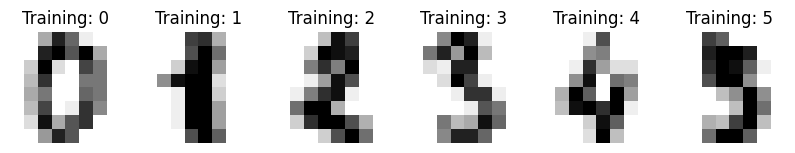

In [144]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

print(f"\nКоличество примеров: {len(digits.data)}")
print("Распределение по классам:")
for i in range(10):
    count = len(digits.target[digits.target == i])
    print(f"Класс {i}: {count} примеров")

std_deviation = digits.data.std()
print("Среднеквадратическое отклонение:", np.round(std_deviation, 2))

In [145]:
X = digits["data"]
Y = digits["target"]

# Нормализация входных векторов
X = normalize(X, norm='max')
X, Y = shuffle(X, Y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

# X_train = X_train[:200]
# X_test = X_test[:50]
# X_val = X_val[:50]

# y_train = y_train[:200]
# y_test = y_test[:50]
# y_val = y_val[:50]

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(862, 64)
(360, 64)
(575, 64)


In [ ]:
# Число эпох
n_epoches = 1000
# Общее количество нейронов в популяции
total_number_neuron = 2000
# Общее количество комбинаций нейронов
total_number_blueprints = 500
# Количество скрытых нейронов в нейронной сети
number_hidden_neurons = 50
# Количество связей у нейрона
number_neuron_connection = 7

patience = 30

# Количество нейронов входного слоя
num_input_neurons = X.shape[1]
# Количество нейронов выходного слоя
num_output_neurons = np.unique(Y).shape[0]

model_id = 1

In [146]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, model_name, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name

    def __call__(
        self, current_valid_loss,
        epoch, model, counter
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            np.save(
                f'/content/drive/MyDrive/Colab Notebooks/NeuroEvo/outputs/models/{self.model_name}_{counter}',
                model
            )

In [147]:
class EarlyStopping:
    """Early stops the training if validation loss
    doesn't improve after a given patience."""
    def __init__(
        self, model_name="model", patience=7
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.save_checkpoint = SaveBestModel(model_name)

    def __call__(
        self, val_loss, model,
        epoch, count
    ):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, epoch, model, count)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, epoch, model, count)
            self.counter = 0